## Solution to Written Assignment 3 of DAMA61 ##

#### Nikos Apostolopoulos (std163710) ####

### Problem 1 ###

Import required libraries.

In [5]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

##### Question 1. #####
Load MNIST dataset and split it into training and test sets.

In [7]:
# load the mnist dataset
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
# split the dataset using stratisfied splitting with a fixed random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# retain the 10000 first entries from the training set and the first 2000 from the test set
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:2000]
y_test = y_test[:2000]
# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# convert the labels from an array of strings to an array of 64-bit integers
lblEncoder = LabelEncoder()
y_train_int = lblEncoder.fit_transform(y_train)
y_test_int = lblEncoder.fit_transform(y_test)

##### Question 2. #####
Perform a Grid Search for a Decision Tree.

In [11]:
# define a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
# define grid search parameters
param_grid = {
    'max_features': [100, 150, 200],
    'max_depth': [2, 4, 5]
}
# define Grid Search with 5-Fold Cross Validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')
# fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train_int)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'max_depth': [2, 4, 5],
                         'max_features': [100, 150, 200]},
             scoring='accuracy')

Print the Grid Search metrics

In [13]:
# get the best estimator
best_model = grid_search.best_estimator_
# make predictions on the test set
y_pred = best_model.predict(X_test_scaled)
# compute accuracy and F1-score
accuracy = accuracy_score(y_test_int, y_pred)
f1_macro = f1_score(y_test_int, y_pred, average='macro')
# print results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score (macro): {f1_macro:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

Test Accuracy: 0.6765
Test F1-Score (macro): 0.6645
Best Parameters: {'max_depth': 5, 'max_features': 150}


In [14]:
# print scores for all parameter combinations
print("\nAll Grid Search Results:")
for params, mean_test_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f"Params: {params}, Mean CV Accuracy: {mean_test_score:.4f}")


All Grid Search Results:
Params: {'max_depth': 2, 'max_features': 100}, Mean CV Accuracy: 0.3162
Params: {'max_depth': 2, 'max_features': 150}, Mean CV Accuracy: 0.3162
Params: {'max_depth': 2, 'max_features': 200}, Mean CV Accuracy: 0.3230
Params: {'max_depth': 4, 'max_features': 100}, Mean CV Accuracy: 0.5627
Params: {'max_depth': 4, 'max_features': 150}, Mean CV Accuracy: 0.5775
Params: {'max_depth': 4, 'max_features': 200}, Mean CV Accuracy: 0.5842
Params: {'max_depth': 5, 'max_features': 100}, Mean CV Accuracy: 0.6507
Params: {'max_depth': 5, 'max_features': 150}, Mean CV Accuracy: 0.6605
Params: {'max_depth': 5, 'max_features': 200}, Mean CV Accuracy: 0.6546


Discuss the results

From the above results it seems that at depth 2 the model is underfitting (the accuracy is very low). At depths 4 and 5 the results are better, with depth 5 having the higher accuracy. The number of features seems to not have a significant impact on the accuracy scores, although the increase in the number of features generally improves the accuracy scores. Nevertheless we see that at depth 5 the increase in the number of features from 150 to 200 actually reduces the accuracy, suggesting that too many features might introduce noise.

##### Question 3. #####
Use PCA and Decision Tree.

In [18]:
# create a pipeline performing PCA and Decision Tree
pipeline = Pipeline([
    ('pca', PCA(n_components=0.90, random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42))
])
# fit the model
pipeline.fit(X_train_scaled, y_train_int)
# make predictions
y_pred = pipeline.predict(X_test_scaled)

Print the PCA metrics

In [20]:
# compute accuracy and F1-score
accuracy_pca = accuracy_score(y_test_int, y_pred)
f1_macro_pca = f1_score(y_test_int, y_pred, average='macro')
# print results
print(f"Test Accuracy (PCA + Decision Tree): {accuracy_pca:.4f}")
print(f"Test F1-Score (macro, PCA + Decision Tree): {f1_macro_pca:.4f}")

Test Accuracy (PCA + Decision Tree): 0.6720
Test F1-Score (macro, PCA + Decision Tree): 0.6682


Discuss the results

We observe that the scores after applying PCA remain roughly the same. Therefore we can conclude that PCA removed the redundant features without significant loss.

##### Question 4. #####
Use PCA and Gradient Boosting.

In [24]:
# create a pipeline performing PCA and Gradient Boosting
pipeline = Pipeline([
    ('pca', PCA(n_components=0.90, random_state=42)),
    ('gbc', GradientBoostingClassifier(max_depth=2, n_estimators=6, learning_rate=1.0, random_state=42))
])
# fit the model
pipeline.fit(X_train_scaled, y_train_int)
# make predictions
y_pred = pipeline.predict(X_test_scaled)

Print the Gradient Boosting metrics

In [26]:
# compute accuracy and F1-score
accuracy_gbc = accuracy_score(y_test_int, y_pred)
f1_macro_gbc = f1_score(y_test_int, y_pred, average='macro')
# print results
print(f"Test Accuracy (PCA + GBC): {accuracy_gbc:.4f}")
print(f"Test F1-Score (macro, PCA + GBC): {f1_macro_gbc:.4f}")

Test Accuracy (PCA + GBC): 0.7940
Test F1-Score (macro, PCA + GBC): 0.7903


Discuss the results

It seems that Gradient Boosting produces a more accurate model. The Decision Tree may have overfitted the data by capturing noise or irrelevant patterns. Even with shallow trees, the boosting process allows it to make better decisions by combining the outputs of several trees, leading to better generalization.

##### Question 5. #####
Reconstuct images and use KMeans.

In [30]:
# apply PCA 
pca = PCA(n_components=0.90, random_state=42)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
# inverse PCA transformation
X_train_scaled_recon = pca.inverse_transform(X_train_scaled_pca)
# inverse scaling
X_train_recon = scaler.inverse_transform(X_train_scaled_recon)
# reshape images
X_orig_img = X_train[:5].reshape(5, 28, 28)
X_recon_img = X_train_recon[:5].reshape(5, 28, 28)

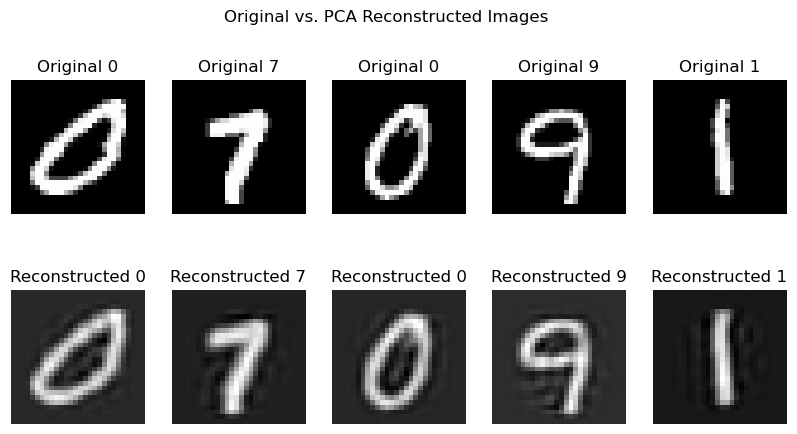

In [31]:
# plot original and reconstructed images side by side
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    axes[0, i].imshow(X_orig_img[i], cmap='gray')
    axes[0, i].set_title(f"Original {y_train[i]}")
    axes[0, i].axis('off')
    axes[1, i].imshow(X_recon_img[i], cmap='gray')
    axes[1, i].set_title(f"Reconstructed {y_train[i]}")
    axes[1, i].axis('off')
plt.suptitle("Original vs. PCA Reconstructed Images")
plt.show()

Discuss the results

The reconstructed images resemble the original digits but appear blurry. We see that 90% variance retention keeps most of the information (shape of the digits), but blurring occurs due to the removal of less significant features.

Use KMeans

In [35]:
# perform KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
kmeans.fit(X_train_scaled_pca)
# get the cluster centroids
centroids_scaled_pca = kmeans.cluster_centers_
# inverse PCA transformation
centroids_scaled = pca.inverse_transform(centroids_scaled_pca)
# inverse scaling
centroids = scaler.inverse_transform(centroids_scaled)
# reshape centroid images
centroids_images = centroids.reshape(20, 28, 28)

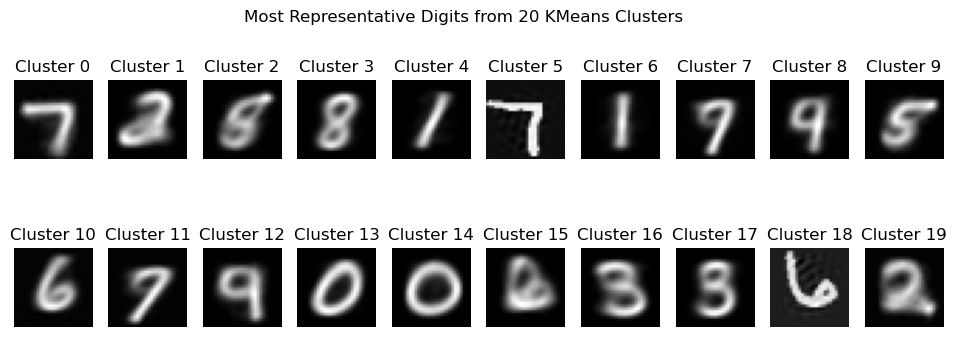

In [36]:
# plot the centroids
fig, axes = plt.subplots(2, 10, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(centroids_images[i], cmap='gray')
    ax.set_title(f"Cluster {i}")
    ax.axis('off')
plt.suptitle("Most Representative Digits from 20 KMeans Clusters")
plt.show()

##### Question 6. #####
Label Propagation.

In [38]:
# manually assign labels to clusters
manual_labels = np.array([7, 2, 5, 8, 1, 7, 1, 9, 4, 5, 6, 7, 9, 0, 0, 8, 3, 3, 6, 2])
# compute distances to centroids
distances = cdist(X_test, centroids, metric='euclidean')
# find the nearest cluster index
nearest_clusters = np.argmin(distances, axis=1)
# assign the cluster's manual label
y_pred = manual_labels[nearest_clusters]

Print the Label Propagation metrics

In [40]:
# compute Accuracy & F1-score
accuracy = accuracy_score(y_test_int, y_pred)
f1_macro = f1_score(y_test_int, y_pred, average='macro')
# print Label Propagation metrics
print(f"Label Propagation Accuracy: {accuracy:.4f}")
print(f"Label Propagation F1-score (macro): {f1_macro:.4f}")

Label Propagation Accuracy: 0.6020
Label Propagation F1-score (macro): 0.5949


Discuss the results

The accuracy and macro F1-score depend on how well the clusters capture digit variations but it seems that the results are less accurate compared to the previous methods.

### Problem 2 ###

Import required libraries.

In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

##### Question 1. #####
Load pima.csv dataset and display information.

In [47]:
# load the dataset
pima = pd.read_csv("datasets/pima.csv", sep=',')
# print the shape of the dataset
print("Dataset Shape:", pima.shape)
# display the distribution of the target variable
distribution = pima['Outcome'].value_counts()
print("Target Variable Distribution:\n", distribution)

Dataset Shape: (768, 9)
Target Variable Distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


##### Question 2. #####
Display feature information and replace zero values.

In [49]:
# display main statistical characteristics of each column
print("Original Dataset Statistics:")
print(pima.describe())
# identify columns with zero minimum values and replace them with median
columns_with_zero_min = []
for col in pima.columns:
    if pima[col].min() == 0 and col != 'Outcome':
        columns_with_zero_min.append(col)
        median_value = pima[col].median()
        pima[col] = pima[col].replace(0, median_value)
# print updated dataset characteristics and affected columns
print("\nUpdated Dataset Statistics:")
print(pima.describe())
print("\nColumns affected by zero-value replacement:", columns_with_zero_min)

Original Dataset Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min   

##### Question 3 #####
Perform a stratified split of the dataset.

In [51]:
# define features (X) and target (y)
X = pima.drop(columns=['Outcome'])  # Feature space
y = pima['Outcome']  # Target variable
# perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=700, stratify=y, random_state=42)
# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Question 4 #####
Train models and calculate performance metrics.

In [53]:
# create models
dectr_clf = DecisionTreeClassifier(random_state=42)
rand_clf = RandomForestClassifier(random_state=42)
bag_clf = BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=10, random_state=42)
ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, learning_rate=0.25, random_state=42)
# train models
dectr_clf.fit(X_train_scaled, y_train)
rand_clf.fit(X_train_scaled, y_train)
bag_clf.fit(X_train_scaled, y_train)
ada_clf.fit(X_train_scaled, y_train)
# make predictions
y_pred_dectr = dectr_clf.predict(X_test_scaled)
y_pred_rand = rand_clf.predict(X_test_scaled)
y_pred_bag = bag_clf.predict(X_test_scaled)
y_pred_ada = ada_clf.predict(X_test_scaled)
# function to print classification results
def print_results(model_name, y_test, y_pred):
    print(f"\nModel: {model_name}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# display results for each model
print_results("Decision Tree", y_test, y_pred_dectr)
print_results("Random Forest", y_test, y_pred_rand)
print_results("Bagging (SVM)", y_test, y_pred_bag)
print_results("AdaBoost (Decision Tree)", y_test, y_pred_ada)


Model: Decision Tree
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77        44
           1       0.58      0.62      0.60        24

    accuracy                           0.71        68
   macro avg       0.68      0.69      0.68        68
weighted avg       0.71      0.71      0.71        68

Confusion Matrix:
 [[33 11]
 [ 9 15]]

Model: Random Forest
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        44
           1       0.73      0.79      0.76        24

    accuracy                           0.82        68
   macro avg       0.81      0.82      0.81        68
weighted avg       0.83      0.82      0.83        68

Confusion Matrix:
 [[37  7]
 [ 5 19]]

Model: Bagging (SVM)
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82        44
           1       0.67

/home/nik/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


##### Question 5 #####
Compare model performance.

##### Question 6 #####
Self training classifier.